In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [3]:
df.shape

(2694, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,7.673272e+07,152572473.5,2.247314e+08,2.998107e+08
world_revenue,2694.0,7.719177e+08,4.284414e+08,3261301.0,3.991135e+08,766555142.5,1.143920e+09,1.499310e+09
opening_revenue,2694.0,9.971321e+07,5.721762e+07,138569.0,5.033848e+07,99814175.0,1.489805e+08,1.999336e+08
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1.161000e+03,2271.5,3.392250e+03,4.499000e+03
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,7.861876e+07,156256716.0,2.274832e+08,2.998597e+08
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,4.700000e+01,91.0,1.350000e+02,1.790000e+02


In [7]:
to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [8]:
df.isnull().sum() * 100 / df.shape[0]

title               0.0
domestic_revenue    0.0
distributor         0.0
opening_theaters    0.0
budget              0.0
MPAA                0.0
genres              0.0
release_days        0.0
dtype: float64

In [9]:
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()

0

In [10]:
df['domestic_revenue'] = df['domestic_revenue'].astype(str).str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].astype(str).str.replace(',', '')  
    temp = (~df[col].isnull()) 
    df[temp][col] = df[temp][col].convert_dtypes(float) 

    df[col] = pd.to_numeric(df[col], errors='coerce')

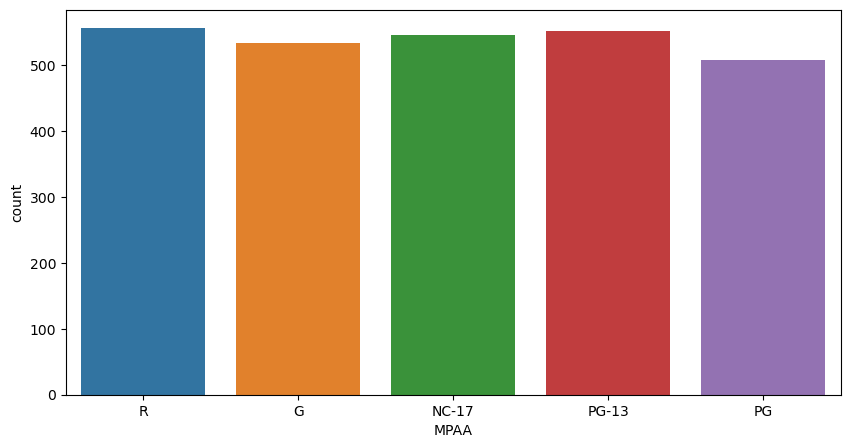

In [11]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

In [12]:
df.groupby('MPAA')['domestic_revenue'].mean()

MPAA
G        3.426099e+07
NC-17    3.452006e+07
PG       3.697347e+07
PG-13    3.510989e+07
R        3.670206e+07
Name: domestic_revenue, dtype: float64

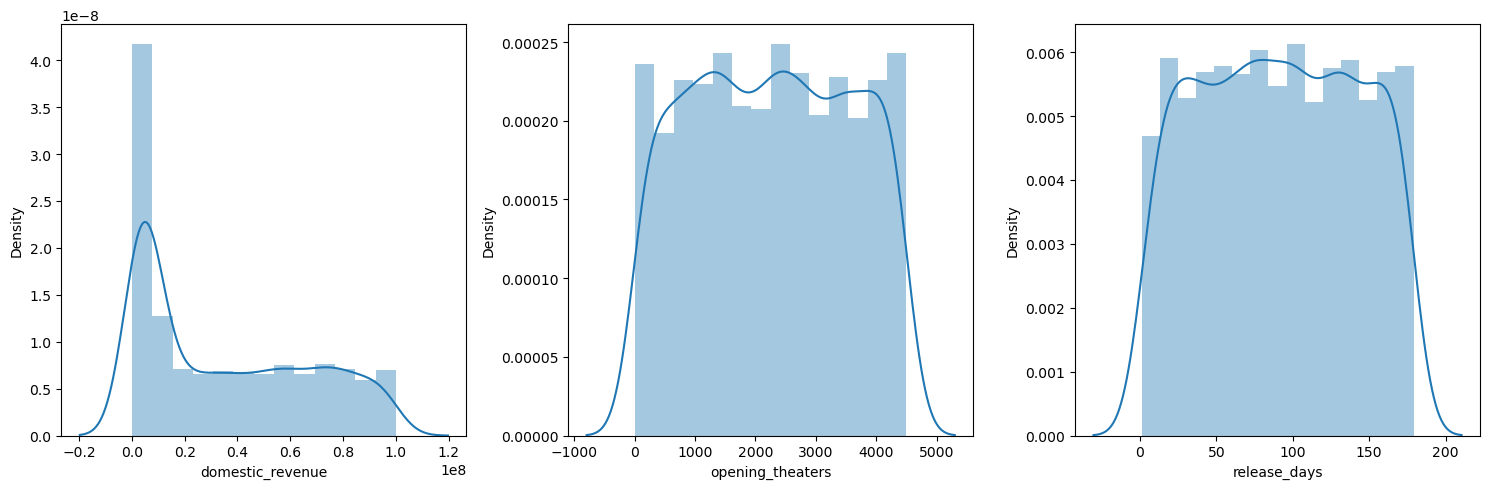

In [13]:
plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

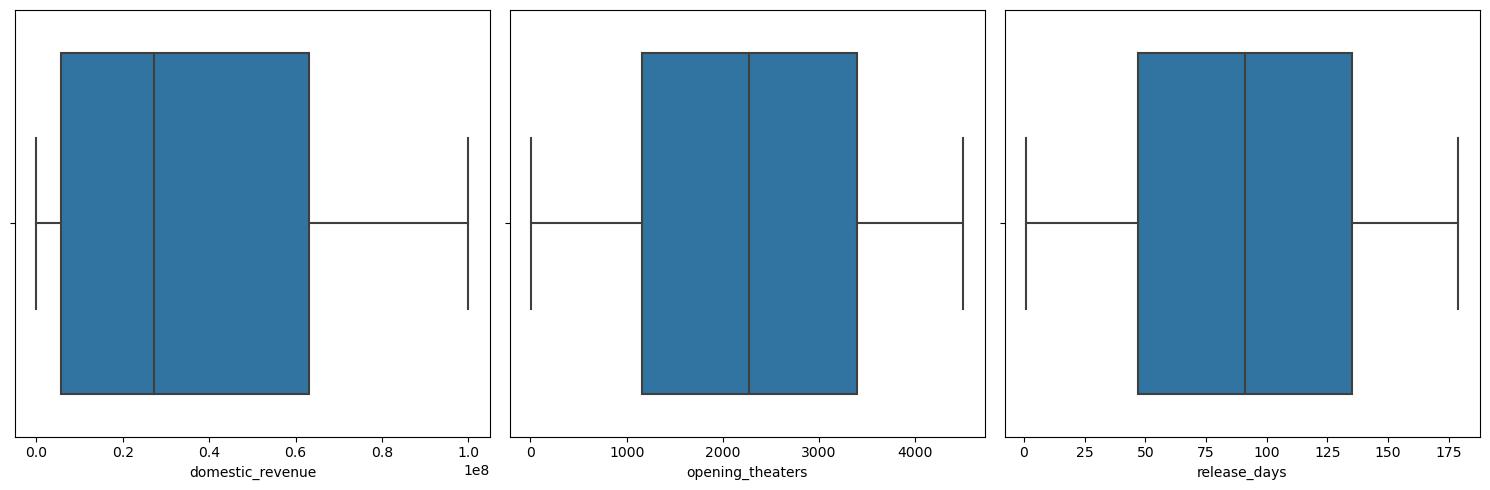

In [14]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [15]:
for col in features:
  df[col] = df[col].apply(lambda x: np.log10(x))

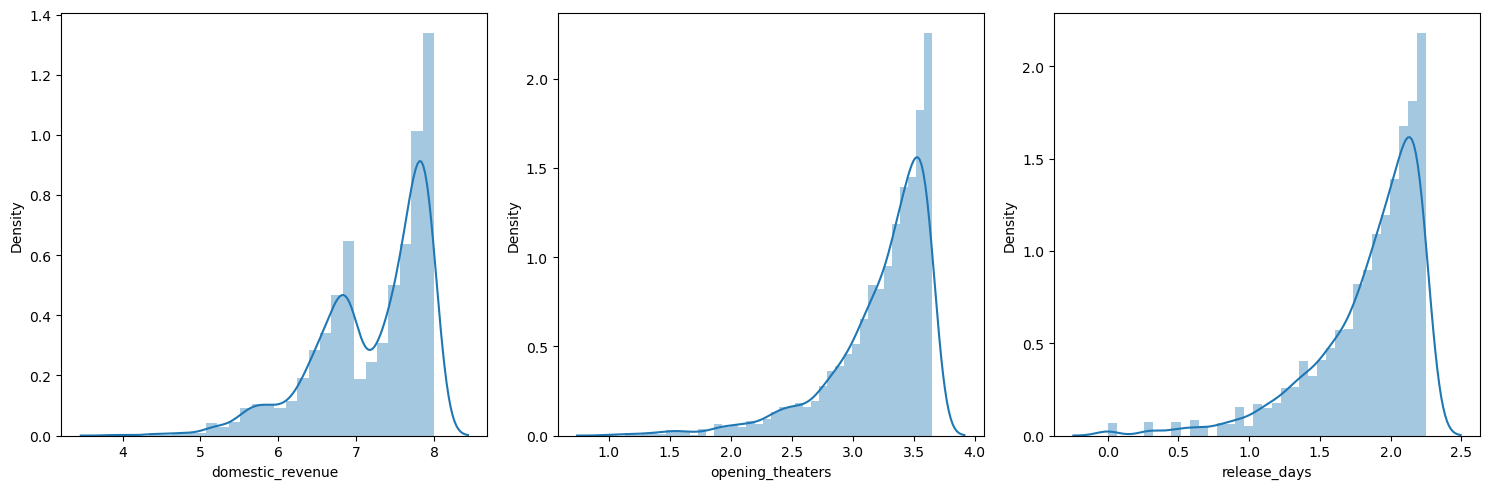

In [16]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [17]:
vectorizer = CountVectorizer() 
vectorizer.fit(df['genres']) 
features = vectorizer.transform(df['genres']).toarray() 

genres = vectorizer.get_feature_names_out() 
for i, name in enumerate(genres): 
	df[name] = features[:, i] 

df.drop('genres', axis=1, inplace=True)

In [18]:
removed = 0
if 'action' in df.columns and 'western' in df.columns:
    for col in df.loc[:, 'action':'western'].columns: 
        if (df[col] == 0).mean() > 0.95: 
            removed += 1
            df.drop(col, axis=1, inplace=True) 

print(removed) 
print(df.shape)

0
(2694, 12)


In [19]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

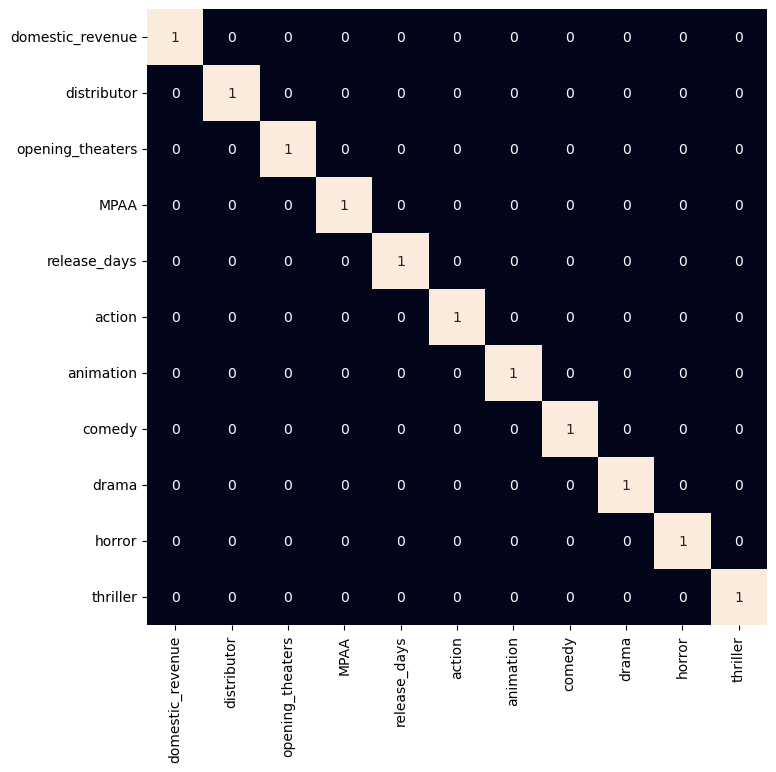

In [20]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.select_dtypes(include=np.number).corr() > 0.8, 
            annot=True, 
            cbar=False) 
plt.show()

In [21]:
features = df.drop(['title', 'domestic_revenue'], axis=1) 
target = df['domestic_revenue'].values 

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.1, random_state=22) 
X_train.shape, X_val.shape 

((2424, 10), (270, 10))

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [30]:
from sklearn.metrics import mean_absolute_error as mae
model = XGBRegressor()
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [31]:
train_preds = model.predict(X_train) 
print('Training Error : ', mae(Y_train, train_preds)) 

val_preds = model.predict(X_val) 
print('Validation Error : ', mae(Y_val, val_preds)) 

Training Error :  0.2486022706753337
Validation Error :  0.6153295230424678
